# Demonstration on FEM error analysis

In this notebook, we numerically illustrate the error from a finite element method by using a Neumann error analysis.

### Recap

We are looking for the solution to the partial differential equation 

$$-\Delta u=f$$ 

on a domain $\Omega$. Here, $\Delta$ is the Laplace operator and $f$ is a known function. We assume that on the boundary of our domain $\partial \Omega$, $u$ takes value $0$.

By multiplication with test function $\phi$ and integration over $\Omega$ we obtain the weak form

$$\int_\Omega\nabla u\cdot \nabla\phi = \int_\Omega f \phi.$$

After discretization, we look for solutions of the form 

$$u = \sum_{j=0}^{n-1}\vec{u}_j\phi_j.$$

We continue with the implementation from the previous notebook, but use a more complicated right hand side function $f$.

In [76]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def solve_poisson(h):
    """
    Solve the poisson equation using the finite element method
    param h: Maximum grid size. We round it down to the nearest `1/n`
    return: a vector of size n containing the solution approximation
    """
    # Number of grid points (rounded up if h is not a reciprocal of an integer)
    n = int(np.ceil(1./h)+1)
    # Make h match the number of grid points
    h = 1./(n-1)
    # Nodes
    xs = np.linspace(0,1,n)
    # Right hand side function (expressed as an anonymous function)
    f = lambda x: - 16*np.exp(4*x) + 2*np.exp(4)-2
    # Using this function, we know the solution must be u=x**2 - x**3
    # Construct the tri-diagonal matrix
    A = (np.diag(2*np.ones(n-2)) + np.diag(-np.ones(n-3),1) + np.diag(-np.ones(n-3),-1))/h
    # Construct the right hand side vector
    # Centers of the elements
    b = h*f(xs[1:-1])
    # Solve the system
    u = np.linalg.solve(A,b)
    return u, xs[1:-1]

h = 1./10
u_approx, centers = solve_poisson(h)


## Error quantification

Before comparing errors, we need to define the error of an approximation. Roughly speaking, it should be a measure of the difference between the approximation and the exact solution.

*Note that in general, we apply FEM because we don't know the solution to the problem. In that case, comparing the approximation with its solution becomes a bit more difficult. Still, mathematically it is often possible to do observations of the error without knowing the solution beforehand.*

A commonly used error metric is the $\mathcal{L}^2$ difference with the exact solution $u$:

$$\left|\left|u - \sum_i u_i \phi_i\right|\right|_{\mathcal{L}^2} = \sqrt{\int_\Omega \left(u(\vec{x}) - \sum_i u_i \phi_i(\vec{x})\right)^2d\vec{x}}$$

We can implement this ourselves to investigate the error and see the solution. Since we have our approximation available through a vector instead of a function, we estimate the error like

$$\left|\left|u - \sum_i u_i \phi_i\right|\right|_{\mathcal{L}^2} \approx \sqrt{\sum_{i} (u(x_i) - u_i)^2}h$$


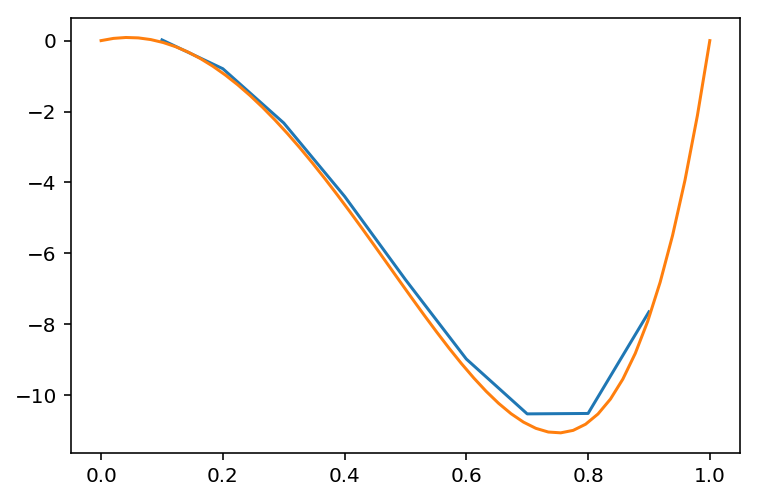

In [79]:
def l2_error(u_exact,u_approx,nodes):
    """
    Approximates the L2 error between a function and a linear approximation vector
    u: anonymous function, exact solution
    u_approx: vector with coefficients defined on nodes
    nodes: vector with grid points
    """
    return np.linalg.norm(u_exact(nodes)-u_approx)/np.sqrt((len(nodes)+2))

u_exact = lambda x: np.exp(4*x) - x**2*(np.exp(4) - 1) - 1
plt.plot(centers,u_approx)
plt.plot(np.linspace(0,1),u_exact(np.linspace(0,1)))
err = l2_error(u_exact,u_approx,centers) # Centers or nodes?

It's possible to prove that the error of the finite element method with linear basis functions is $\mathcal{O}(h^2)$.
This means that the leading order error term is proportional to $h^2$. In other words, if you decrease $h$ by a factor 2, the error will decrease roughly by a factor 4. We can show this for our example by varying the values of $h$.

Ratio of subsequent errors: [ 3.62990428  3.84917476  3.93139033  3.96724832  3.98400156  3.99209431
  3.99607047  3.99804097  3.99902508]


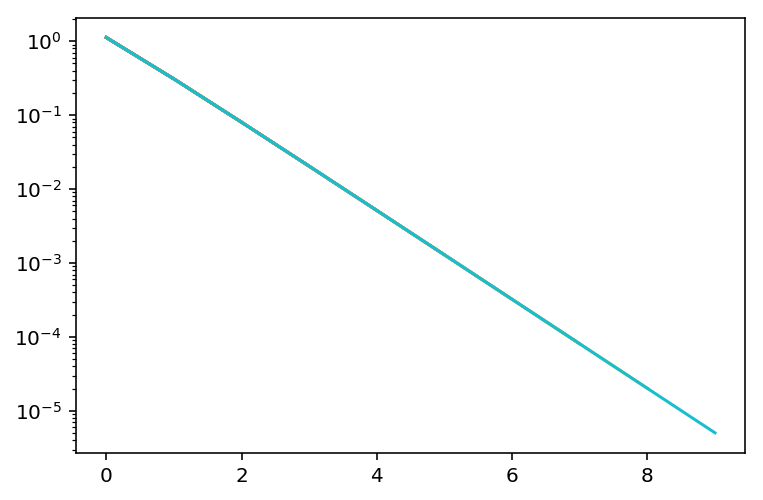

In [83]:
num_points = 10
err = np.zeros(num_points)
for i in range(num_points):
    h = 1./2**(i+2)
    u_approx,centers = solve_poisson(h)
    err[i] = l2_error(u_exact,u_approx,centers)
    plt.semilogy(range(num_points),err)
print("Ratio of subsequent errors:",(err[:-1]/err[1:]))
    

Now we have been looking at local and global errors. There is a different way to quantify the precision of a numerical approximation, and that is by looking at the frequency of the error. We will apply a fourier stability analysis here. In time-dependent finite difference methods this is often referred to as a Von Neumann stability analysis.